In [1]:
!pip freeze > '../working/requirements.txt'

# Abroad detector - RIA.com

Task - fraud detection classification. Problem - imbalanced data. We would like to maximize true positive rate (TPR), precision of minority class - the metric we want to optimize. Model without any preprocessing shows that results:

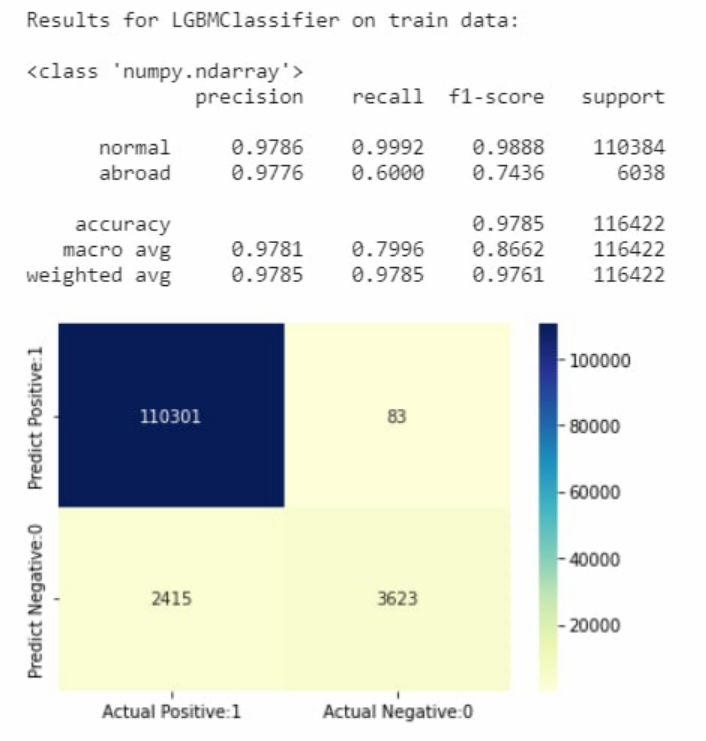
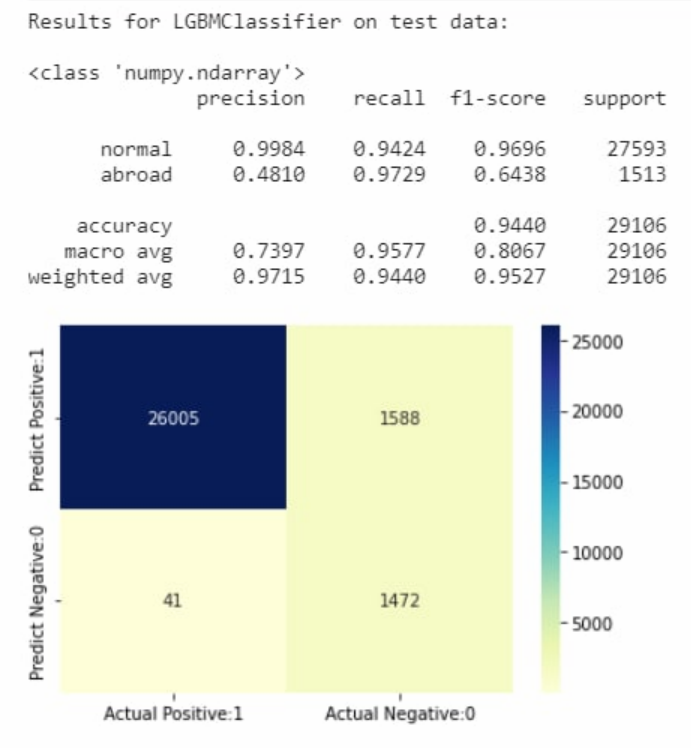

In order to change it I used oversampling method - SMOTE. Preprocessing include log transformation (reduce skewed), removing columns, different types of encoding, filling missing val (then one value appeared), spliting and scaling methods.

The choice of the model fell on XGBoost(chose between xgb and lgbm, xgboost on that data shows better res). I didn't choose the best hyperparameters because it would take a lot of time and the model shows good results (if they are correct), but it it is very easy to do with GridSearchCV. Just in case, I will leave the commented stacking code (and LGBM), which slightly improves performance:

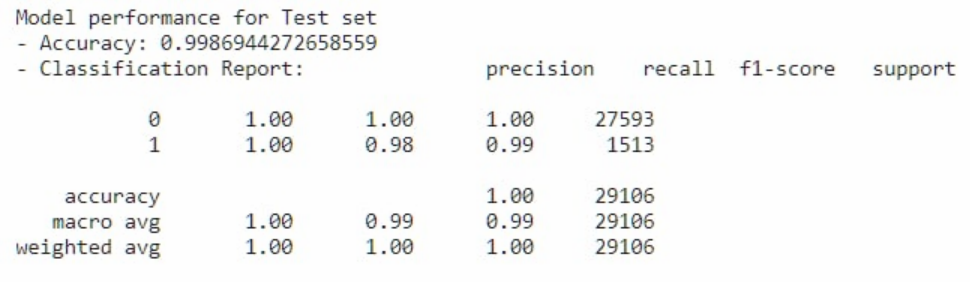

Perfomance XGBoost on test set:

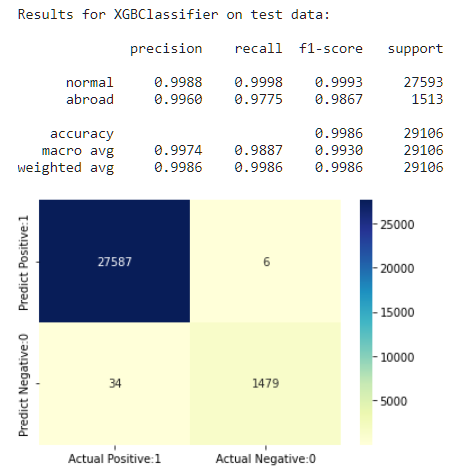

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
# from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import seaborn as sns

import xgboost
import lightgbm as lgb

import pickle
import os
from sklearn.linear_model import LogisticRegression

pd.set_option('max_columns', None)
pd.set_option('max_rows', 1000)

In [3]:
# 0-sufix -- all for train dataset
# 00-sufix -- all for test dataset
train0 = pd.read_csv('../input/auto-ria/abroad_dataset_train.csv')
test00 = pd.read_csv('../input/auto-ria/abroad_dataset_test.csv')

In [4]:
def outliers (df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    # take outlier values 
    ls = df.loc[ (df[ft] < lower_bound) | (df[ft] > upper_bound), ft ]
    return ls


In [5]:
index_list = []
for feature in ['raceGroup']:
    index_list.extend(outliers(train0, feature))

In [6]:
def replace(df, ls):
    ls = sorted(set(ls))
    df.loc[df['raceGroup']> ls, 'raceGroup'] = np.nan
    df.fillna(median1, inplace=True)

In [7]:
Q1 = train0['raceGroup'].quantile(0.25)
Q3 = train0['raceGroup'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

In [8]:
# for i in index_list:
train0.loc[ (train0['raceGroup'] < lower_bound), 'raceGroup' ] = 0
train0.loc[(train0['raceGroup'] > upper_bound), 'raceGroup' ] = 467000

In [9]:
train0.drop(['GPS', 'agvPriceScore', 'description'], axis=1, inplace=True)

In [10]:
null_data = train0[train0.isnull().any(axis=1)]
null_data.head(10)

,argCompleteTime,argPublicationTime,auctionPossible,autoCount,autoDontComment,bedPhotoPropCount,color,contactViaEmail,countOfActiveAuto,countOfSoldAuto,currency_id,custom,damage,driveType,engineVolume,fuel,gear,hideRegistration,isAutoFromBigCity,isAutoseller,isCardPayer,isCommertial,isExchange,isHaveCameraModel,isHaveLensInfo,isInTZReestr,isLeasing,isMobile,isNpDetected,is_new,marka,matchedCountry,metallic,nFuelRates,nPhonesChecked,npRegion,onRepairParts,optionsAll,phoneLastChange,photoTags,priceGroup,raceGroup,registrationPeriod,salonCount,seats,sendComments,socialCount,underCredit,userAvatarExists,userEmailVerified,versionExists,vinCheck,withPhoto,withVideo,year,label


In [11]:
def preproc(df):
    """
        Preprocess data
            Parameters:
                df - pandas.Dataframe
            Returns:
                X_train_sm, X_test, y_train_sm, y_test - pandas.core.frame.DataFrame
    """
    df = df.copy()
    
    log_transform(df)
    print('1')
    # Drop not useful features 
#     df = df.drop(['GPS', 'agvPriceScore', 'description'], axis=1)
    print('2')

    pd.get_dummies(df)
#     df = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)

    # Make dataset
    y = df['label'].copy()
    le = LabelEncoder()
    # From 0.0 to 0
    y_transformed = le.fit_transform(y)
    
    X = df.drop('label', axis=1).copy()
    
    # Fill 1 missing val
    X['argPublicationTime'].fillna((X['argPublicationTime'].mean()), inplace=True)
    print('3')

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_transformed, test_size=0.2, random_state=123)
    print('4')

    # Oversampling only to train data
    smote = SMOTE(sampling_strategy='minority')
#     nearmiss = NearMiss(version=3)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    print(Counter(y_train_sm))

    # Scaler
    scaler = StandardScaler()
    scaler.fit(X_train_sm)

    X_train_sm = pd.DataFrame(scaler.transform(X_train_sm), index=X_train_sm.index, columns=X_train_sm.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train_sm, X_test, y_train_sm, y_test

In [12]:
def log_transform(df):
    """
        Transform feature in df
            Parameters:
                df - pandas.Dataframe
    """
    skew_df = pd.DataFrame(df.select_dtypes(np.number).columns, columns=['Feature'])
    skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature]))
    skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
    skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x>=0.5 else False)
#     skew_df

    # Apply for skewed columns log transform
    for colunm in skew_df.query('Skewed == True')['Feature'].values:
        df[colunm] = np.log1p(df[colunm])

    return df

In [13]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## Some Eda

In [14]:
{column: len(train0[column].unique()) for column in train0.columns}

{'argCompleteTime': 16567,
 'argPublicationTime': 57957,
 'auctionPossible': 2,
 'autoCount': 5874,
 'autoDontComment': 2,
 'bedPhotoPropCount': 133,
 'color': 12,
 'contactViaEmail': 2,
 'countOfActiveAuto': 554,
 'countOfSoldAuto': 1431,
 'currency_id': 3,
 'custom': 2,
 'damage': 2,
 'driveType': 7,
 'engineVolume': 525,
 'fuel': 10,
 'gear': 6,
 'hideRegistration': 2,
 'isAutoFromBigCity': 2,
 'isAutoseller': 2,
 'isCardPayer': 2,
 'isCommertial': 2,
 'isExchange': 4,
 'isHaveCameraModel': 2,
 'isHaveLensInfo': 2,
 'isInTZReestr': 2,
 'isLeasing': 2,
 'isMobile': 2,
 'isNpDetected': 2,
 'is_new': 3,
 'marka': 1961,
 'matchedCountry': 49,
 'metallic': 2,
 'nFuelRates': 6,
 'nPhonesChecked': 10,
 'npRegion': 15,
 'onRepairParts': 2,
 'optionsAll': 107,
 'phoneLastChange': 3260,
 'photoTags': 241,
 'priceGroup': 14243,
 'raceGroup': 571,
 'registrationPeriod': 4512,
 'salonCount': 2,
 'seats': 97,
 'sendComments': 2,
 'socialCount': 5,
 'underCredit': 2,
 'userAvatarExists': 2,
 'user

<AxesSubplot:>

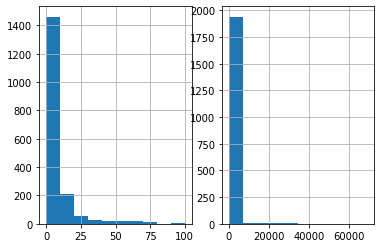

In [15]:
# Uniq auto
fig, axes = plt.subplots(1, 2)

train0['marka'].value_counts().hist( ax=axes[0], range=[0, 100])
train0['marka'].value_counts().hist(  ax=axes[1])

In [16]:
train0.label.value_counts()

0    552093
1     30014
Name: label, dtype: int64

<AxesSubplot:>

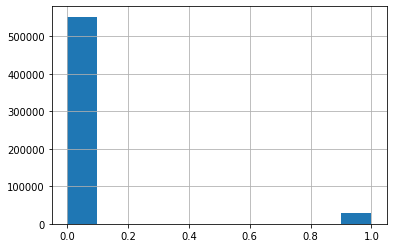

In [17]:
train0.label.hist()

# Train dataset

In [18]:
X_train_sm0, X_test0, y_train_sm0, y_test0 = preproc(train0)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


1
2
3
4
Counter({0: 441709, 1: 441709})


In [19]:
def show_cm(cm):
    """
    Show confusion matrix
        Parameters:
            cm - class 'numpy.ndarray'
    """
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [20]:
def save_model(model):
    path_to_file = './model.pkl'
    filename = 'model.pkl'
    if not os.path.exists(path_to_file):
        pickle.dump(model, open(filename, 'wb'))

In [21]:
def predict_show(model, X_test, y_test):
    """
    Train model and returns classification report
        Parameters:
            model - classification model
            X_train_sm, X_test, y_train_sm, y_test - pandas.core.frame.DataFrame
    """
    
    print(f'Results for {type(model).__name__} on {"train data:" if X_test is X_test0 else "test data:"}\n')
    
    # if haven't model - save her
#     save_model(model)
    pred = train_model.predict(X_test)

    class_names = ['normal', 'abroad']
    # Make and show conf matr
    cm = confusion_matrix(y_test, pred)
    show_cm(cm)

    return print(classification_report(y_test, pred, target_names=class_names, digits=4))

In [22]:
# Check shapes
print(
    X_train_sm0.shape, '\n',
    X_test0.shape, '\n',
    y_train_sm0.shape, '\n',
    y_test0.shape,  '\n',
)

(883418, 55) 
 (116422, 55) 
 (883418,) 
 (116422,) 



In [23]:
# For stacking
lgb_clf = lgb.LGBMClassifier()

In [24]:
lr = LogisticRegression(random_state=0)

In [25]:
xgb_clf = xgboost.XGBClassifier(tree_method='gpu_hist')

In [26]:
# parameters = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
#              }

In [27]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import *


# clf = GridSearchCV(xgb_clf, parameters, n_jobs=-1, 
#                    cv=5,
#                    scoring='roc_auc',
#                    verbose=2, refit=True)

# clf.fit(X_train_sm0, y_train_sm0)

In [28]:
# print(clf.score(X_train_sm0, y_train_sm0))
# print(clf.score(X_test0, y_test0))

In [29]:
# print(clf.best_params_)

In [30]:
# xgb_clf = xgboost.XGBClassifier(tree_method='gpu_hist',
#                                learning_rate=0.1, max_depth= 5, n_estimators= 140)

Results for LGBMClassifier on train data:

              precision    recall  f1-score   support

      normal     0.9990    0.9997    0.9993    110384
      abroad     0.9938    0.9815    0.9876      6038

    accuracy                         0.9987    116422
   macro avg     0.9964    0.9906    0.9935    116422
weighted avg     0.9987    0.9987    0.9987    116422



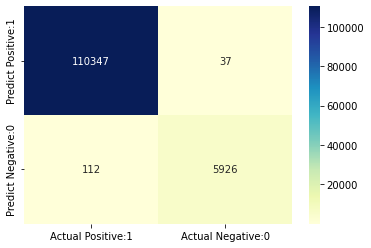

In [31]:
train_model = lgb_clf.fit(X_train_sm0, y_train_sm0)
# save_model(model)
predict_show(lgb_clf, X_test0, y_test0)

# Test dataset

In [32]:
test00.drop(['GPS', 'agvPriceScore','description'], axis=1, inplace=True)

In [33]:
Q1 = test00['raceGroup'].quantile(0.25)
Q3 = test00['raceGroup'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

In [34]:
# for i in index_list:
test00.loc[ (test00['raceGroup'] < lower_bound), 'raceGroup' ] = 0
test00.loc[ (test00['raceGroup'] > upper_bound), 'raceGroup' ] = 478

In [35]:
null_data = test00[test00.isnull().any(axis=1)]
null_data.head(10)

,argCompleteTime,argPublicationTime,auctionPossible,autoCount,autoDontComment,bedPhotoPropCount,color,contactViaEmail,countOfActiveAuto,countOfSoldAuto,currency_id,custom,damage,driveType,engineVolume,fuel,gear,hideRegistration,isAutoFromBigCity,isAutoseller,isCardPayer,isCommertial,isExchange,isHaveCameraModel,isHaveLensInfo,isInTZReestr,isLeasing,isMobile,isNpDetected,is_new,marka,matchedCountry,metallic,nFuelRates,nPhonesChecked,npRegion,onRepairParts,optionsAll,phoneLastChange,photoTags,priceGroup,raceGroup,registrationPeriod,salonCount,seats,sendComments,socialCount,underCredit,userAvatarExists,userEmailVerified,versionExists,vinCheck,withPhoto,withVideo,year,label


In [36]:
_, X_test00, _, y_test00 = preproc(test00)

1
2
3
4
Counter({0: 110431, 1: 110431})


In [37]:
np.unique(Counter(y_test00))

array([Counter({0: 27593, 1: 1513})], dtype=object)

Results for LGBMClassifier on test data:

              precision    recall  f1-score   support

      normal     0.9994    0.9009    0.9476     27593
      abroad     0.3541    0.9907    0.5218      1513

    accuracy                         0.9056     29106
   macro avg     0.6768    0.9458    0.7347     29106
weighted avg     0.9659    0.9056    0.9255     29106



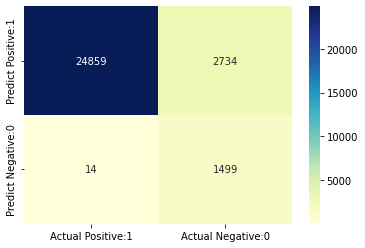

In [38]:
predict_show(lgb_clf, X_test00, y_test00)

(0.0, 1.0)

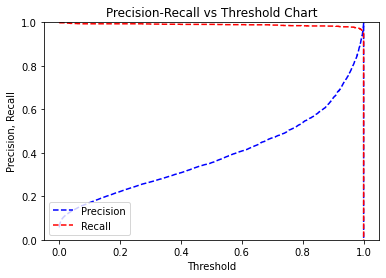

In [39]:
from sklearn.metrics import precision_recall_curve
pred_y=lgb_clf.predict(X_test00) 

probs_y=lgb_clf.predict_proba(X_test00) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first   column of   array) vs 1 (2nd column in array)

import sklearn.metrics as metrics
precision, recall, thresholds = precision_recall_curve(y_test00, probs_y[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [40]:
probs_y

array([[0.99614543, 0.00385457],
       [0.98820895, 0.01179105],
       [0.84390928, 0.15609072],
       ...,
       [0.99699611, 0.00300389],
       [0.98765714, 0.01234286],
       [0.99704687, 0.00295313]])

In [41]:
pred_proba_df = pd.DataFrame(lgb_clf.predict_proba(X_test00))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.precision_score(np.asmatrix(y_test00).reshape(np.asmatrix(y_test00).size,1),
                                           np.asmatrix(Y_test_pred.iloc[:,1]).reshape(np.asmatrix(Y_test_pred.iloc[:,1]).size,1))
    print('Our precision is {}'.format(test_accuracy))

    print(confusion_matrix(np.asmatrix(y_test00).reshape(np.asmatrix(y_test00).size,1),
                           np.asmatrix(Y_test_pred.iloc[:,1]).reshape(np.asmatrix(Y_test_pred.iloc[:,1]).size,1)))


******** For i = 0.05 ******
Our precision is 0.1384954938385139
[[18225  9368]
 [    7  1506]]

******** For i = 0.1 ******
Our precision is 0.1704081632653061
[[20276  7317]
 [   10  1503]]

******** For i = 0.15 ******
Our precision is 0.1976071522482251
[[21490  6103]
 [   10  1503]]

******** For i = 0.2 ******
Our precision is 0.22161604246534947
[[22314  5279]
 [   10  1503]]

******** For i = 0.25 ******
Our precision is 0.24482814790682522
[[22957  4636]
 [   10  1503]]

******** For i = 0.3 ******
Our precision is 0.26618194715375065
[[23455  4138]
 [   12  1501]]

******** For i = 0.35 ******
Our precision is 0.28647822765469827
[[23857  3736]
 [   13  1500]]

******** For i = 0.4 ******
Our precision is 0.3085631947303417
[[24234  3359]
 [   14  1499]]

******** For i = 0.45 ******
Our precision is 0.3334074733096085
[[24596  2997]
 [   14  1499]]

******** For i = 0.5 ******
Our precision is 0.3541223718403024
[[24859  2734]
 [   14  1499]]

******** For i = 0.55 ******
O

### Here you can calibrate the threshold for classification

              precision    recall  f1-score   support

           0     0.9995    0.8500    0.9187     27593
           1     0.2662    0.9921    0.4197      1513

    accuracy                         0.8574     29106
   macro avg     0.6328    0.9211    0.6692     29106
weighted avg     0.9614    0.8574    0.8928     29106



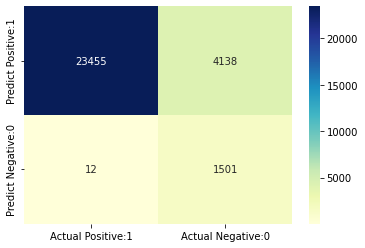

In [42]:
# clf = DecisionTreeClassifier(random_state = 2)
lgb_clf.fit(X_train_sm0,y_train_sm0)
# y_pred = clf.predict(X_test)  # default threshold is 0.5
pred = (lgb_clf.predict_proba(X_test00)[:,1] >= 0.3).astype(bool) # set threshold as 0.3
cm = confusion_matrix(y_test00, pred)
show_cm(cm)

print(classification_report(y_test00, pred, digits=4))

## Staking give higer precision with same recall - good result!

              precision    recall  f1-score   support

      normal     0.9994    0.9302    0.9636     27593
      abroad     0.4375    0.9901    0.6068      1513

    accuracy                         0.9333     29106
   macro avg     0.7185    0.9601    0.7852     29106
weighted avg     0.9702    0.9333    0.9450     29106



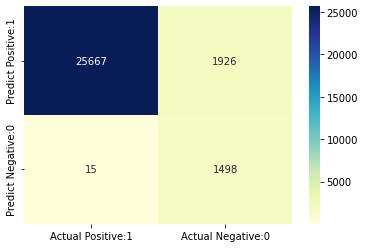

In [43]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('lr',lgb_clf),
    ('xgb',lr), ]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_model.fit(X_train_sm0, y_train_sm0)

# Make predictions
y_test_pred = stack_model.predict(X_test00)

# Test set model performance
# stack_model_test_accuracy = accuracy_score(y_test00, y_test_pred)
# class_report = classification_report(y_test00, y_test_pred)


# print('Model performance for Test set')
# print('- Accuracy: %s' % stack_model_test_accuracy)
# print('- Classification Report: %s' % class_report)


class_names = ['normal', 'abroad']
# Make and show conf matr
cm = confusion_matrix(y_test00, y_test_pred)
show_cm(cm)

print(classification_report(y_test00, y_test_pred, target_names=class_names, digits=4))

In [44]:
train0 = reduce_mem_usage(train0)
train0.info()

Memory usage after optimization is: 51.63 MB
Decreased by 78.6%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582107 entries, 0 to 582106
Data columns (total 56 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   argCompleteTime     582107 non-null  int32  
 1   argPublicationTime  582107 non-null  int32  
 2   auctionPossible     582107 non-null  int8   
 3   autoCount           582107 non-null  int16  
 4   autoDontComment     582107 non-null  float16
 5   bedPhotoPropCount   582107 non-null  float16
 6   color               582107 non-null  float16
 7   contactViaEmail     582107 non-null  int8   
 8   countOfActiveAuto   582107 non-null  int16  
 9   countOfSoldAuto     582107 non-null  int16  
 10  currency_id         582107 non-null  int8   
 11  custom              582107 non-null  int8   
 12  damage              582107 non-null  int8   
 13  driveType           582107 non-null  float16
 14  engineVolume        

# Thank you for an interesting task!